In [1]:
#Importing relevant libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
features_df = pd.read_csv('features_dataset.csv')
features_df

,label,TTR,text_polarity,text_subjectivity,title_polarity,title_subjectivity,doc_perplexity,1_grams,average_word_length
0,1,0.844037,0.091481,0.524184,-0.125000,0.125000,0.867938,"['donald', 'trump', 'met', 'member', 'nato', '...",6.490826
1,0,0.683438,0.003001,0.343395,0.000000,0.000000,0.882860,"['washington', 'reuters', 'rick', 'perry', 'pr...",6.385744
2,1,0.721030,0.073622,0.401345,0.000000,1.000000,0.883760,"['president', 'obama', 'blasted', 'republican'...",6.072961
3,1,0.667638,0.037264,0.462935,0.000000,1.000000,0.882882,"['male', 'idaho', 'republican', 'daughter', 'c...",6.469388
4,1,0.628032,-0.018966,0.479310,-0.800000,0.900000,0.883120,"['kellyanne', 'conway', 'tried', 'spin', 'whit...",6.296496
...,...,...,...,...,...,...,...,...,...
13829,0,0.659631,-0.030698,0.380595,0.000000,0.000000,0.882810,"['washington', 'reuters', 'member', 'congress'...",6.514512
13830,1,0.629126,-0.009035,0.312617,-0.066667,0.633333,0.895444,"['far', 'video', '530000', 'view', 'make', 'co...",6.782524
13831,0,0.595745,0.049287,0.244648,0.000000,0.000000,0.883645,"['dec', '27', 'story', 'corrects', 'say', '550...",6.117021
13832,0,0.696581,-0.026939,0.293520,0.000000,0.000000,0.895276,"['madrid', 'reuters', 'spain', 'high', 'court'...",6.478632


In [3]:
#Printing the datatypes to understand the different features
features_df.dtypes

label                    int64
TTR                    float64
text_polarity          float64
text_subjectivity      float64
title_polarity         float64
title_subjectivity     float64
doc_perplexity         float64
1_grams                 object
average_word_length    float64
dtype: object

# Relevant Data Preparation

As seen from above, 1_grams is not numerical, and therefore we need to convert it to numerical values to enable modelling with the entire dataset

We therefore start by cleaning the data, and then we seperate it into training and test sets

In [3]:
# Initialize vectorizer to convert 1_grams to a fitting datatype
vectorizer = CountVectorizer()

# Vectorize text data
X_vectorized = vectorizer.fit_transform(features_df['1_grams'])

# Drop 1_grams column and convert df to a sparse DataFrame to concatenate with X_vectorized
df_dropped = features_df.drop('1_grams', axis=1).astype(float) # Convert other columns to float
from scipy.sparse import csr_matrix, hstack
df_dropped_sparse = csr_matrix(df_dropped.values)  # Convert DataFrame to sparse matrix
X_final = hstack([df_dropped_sparse, X_vectorized])  # Concatenate the matrices

In [4]:
# We then convert columns to numeric and furthermore look for negative values as these also needs to be normalized
def check_negatives(dataframe):
    negative_counts = {}
    for column in dataframe.columns:
        # Convert column to numeric, non-convertible values become NaN
        converted_column = pd.to_numeric(dataframe[column], errors='coerce')
        # Count negative values
        count = (converted_column < 0).sum()
        if count > 0:
            negative_counts[column] = count
    return negative_counts

# Apply the function to your DataFrame
negative_columns = check_negatives(features_df)

# Print the columns with negative values and their counts
print("Columns with negative values and their counts:")
for column, count in negative_columns.items():
    print(f"{column}: {count} negatives")

Columns with negative values and their counts:
text_polarity: 3097 negatives
title_polarity: 3117 negatives


In [5]:
def check_negatives_exclude_non_numeric(dataframe):
    negative_counts = {}
    for column in dataframe.columns:
        # Attempt to convert column to numeric
        converted_column = pd.to_numeric(dataframe[column], errors='coerce')
        # Continue only if the column is numeric
        if converted_column.dtype != 'object':
            # Count negative values
            count = (converted_column < 0).sum()
            if count > 0:
                negative_counts[column] = count
    return negative_counts

In [6]:
# Converting all columns to numeric, handling non-numeric gracefully
df = features_df.apply(pd.to_numeric, errors='coerce')

# Fill NaN values that result from conversion errors
df.fillna(0, inplace=True)

# Initialize scaler
scaler = MinMaxScaler()

# Fit and transform the data to scale each feature to [0, 1] range
df_scaled = scaler.fit_transform(df.drop('label', axis=1))

# Split the data into features and target
X = df_scaled
y = df['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MultinomialNB

In [22]:
# Initialize the Multinomial Naive Bayes classifier
model = MultinomialNB()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", report)

Accuracy: 0.6176364293458619
Confusion Matrix:
 [[954 399]
 [659 755]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.71      0.64      1353
           1       0.65      0.53      0.59      1414

    accuracy                           0.62      2767
   macro avg       0.62      0.62      0.62      2767
weighted avg       0.62      0.62      0.62      2767



Optimizing the model using gridsearch to increase performance

In [23]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score: {:.2f}".format(grid_search.best_score_))

# Evaluate using the best parameters
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best parameters: {'C': 10, 'kernel': 'rbf'}
Best CV score: 0.72
Test Accuracy: 0.7217202746657029
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.78      0.73      1353
           1       0.76      0.67      0.71      1414

    accuracy                           0.72      2767
   macro avg       0.73      0.72      0.72      2767
weighted avg       0.73      0.72      0.72      2767



Now we want to vizualise the confusion matrix as well

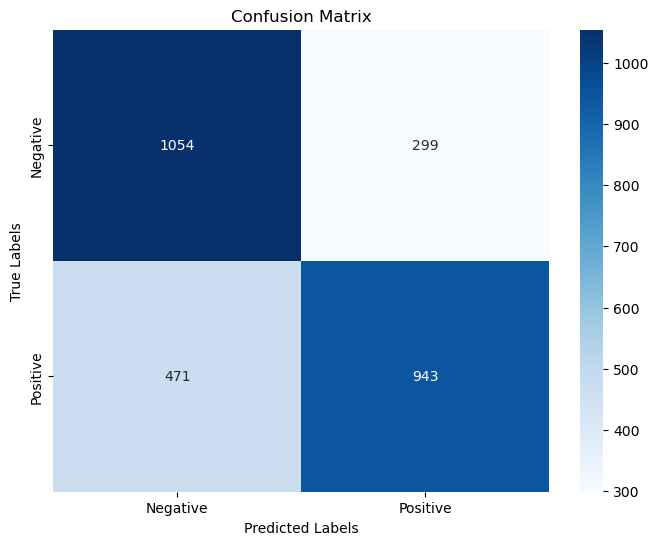

In [24]:
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Logistic Regression

In [8]:
# create and train model
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

# make predictions
y_pred = logistic_regression_model.predict(X_test)

In [9]:
# performance metrics
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1353
           1       0.72      0.68      0.70      1414

    accuracy                           0.70      2767
   macro avg       0.70      0.70      0.70      2767
weighted avg       0.70      0.70      0.70      2767

Confusion Matrix:
 [[975 378]
 [451 963]]
Accuracy Score: 0.7003975424647633


### Tuning of Logistic Regression model

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model with 'liblinear' solver
logistic_regression = LogisticRegression(solver='liblinear')

# Create a dictionary of all values you want to test for C and penalty
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # The norm used in the penalization
}

# Use GridSearchCV to search for the best parameters
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit the grid search model with your training data
grid_search.fit(X_train, y_train)

# Output the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01

In [11]:
# Using the best estimator to make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output the evaluation results
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_mat)
print('Classification Report:\n', report)

Accuracy: 0.6985905312612938
Confusion Matrix:
 [[972 381]
 [453 961]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.72      0.70      1353
           1       0.72      0.68      0.70      1414

    accuracy                           0.70      2767
   macro avg       0.70      0.70      0.70      2767
weighted avg       0.70      0.70      0.70      2767



# Random Forest Model

In [7]:
# Train a Random Forest model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# Make predictions
y_pred = random_forest.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8015901698590532
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1353
           1       0.81      0.81      0.81      1414

    accuracy                           0.80      2767
   macro avg       0.80      0.80      0.80      2767
weighted avg       0.80      0.80      0.80      2767



Now we use gridSearch to find and use  the optimal hyperparameters, to increase the performance of the Random Forest model even more

In [8]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest classifier
random_forest = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: 

In [20]:
# Calculate training accuracy
train_accuracy = best_model.score(X_train, y_train)

# Calculate testing accuracy
test_accuracy = best_model.score(X_test, y_test)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 1.0
Testing Accuracy: 0.8044813877846043


# SVM feature based model

Because 1_grams is text based it needs to be vectorized to enable the model to understand it.
Therefore we split the dataset in both numerical and text-based features, and the we vectorize the 1_grams.

In [14]:
# Initialize the SVM classifier
model = SVC(kernel='linear', C=1.0)

# Train the SVM model
model.fit(X_train, y_train)


SVC(kernel='linear')

In [15]:
# Predict the test set
predictions = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))


Accuracy: 0.6975063245392121
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.74      0.71      1353
           1       0.73      0.66      0.69      1414

    accuracy                           0.70      2767
   macro avg       0.70      0.70      0.70      2767
weighted avg       0.70      0.70      0.70      2767

